# Clip a Spatial Vector Layer Using SHapely & GeoPandas

## How to clip vector data in python

### What is clipping or cropping data?

When you clip or crop spatial data you are removing the data outside of the clip extent. This means that your clipped dataset will be SMALLER (have a smaller spatial extent) than the original dataset. This also means that objects in the data such as polygons or lines will be CUT based on the boundary of the clip object.

![spatial extent](spatial-extent.png)

### When do you want to clip data?

1. You have more data than you need
2. If you have data outside of your study area and you clip it, you can perform analysis on only that region
3. When you plot the data you will only see the study region

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Load the box module from shapely to create bex objects
from shapely.geometry import box
import earthpy as et
import seaborn as sns

# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings("ignore", "GeoSeries.notna", UserWarning)

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set work dir and get data
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

## How to clip shapefiles

In your dataset for this, you have 3 layers:
1. A country boundary for the USA and
2. A state boundary for the USA and
3. Populated places in the USA

The data are imported and plotted below. Notice that there are points outside your study area which is the continental USA. Your goal is to clip the points out that you NEED for your project - the projects that overlay on top of the continental US.

In [2]:
# Import all of your data at the top of your notebook to keep things organised.
country_boundary_us_path = os.path.join("data", "spatial-vector-lidar",
                                       "usa", "usa-boundary-dissolved.shp")
country_boundary_us = gpd.read_file(country_boundary_us_path)

state_boundary_us_path = os.path.join("data", "spatial-vector-lidar",
                                     "usa", "usa-states-census-2014.shp")
state_boundary_us = gpd.read_file(state_boundary_us_path)

pop_places_path = os.path.join("data", "spatial-vector-lidar", "global",
                              "ne_110m_populated_places_simple", "ne_110m_populated_places_simple.shp")
pop_places = gpd.read_file(pop_places_path)

# Are the data all in the same crs?
print("country_boundary_us", country_boundary_us.crs)
print("state_boundary_us", state_boundary_us.crs)
print("pop_places", pop_places.crs)

country_boundary_us epsg:4326
state_boundary_us epsg:4326
pop_places epsg:4326


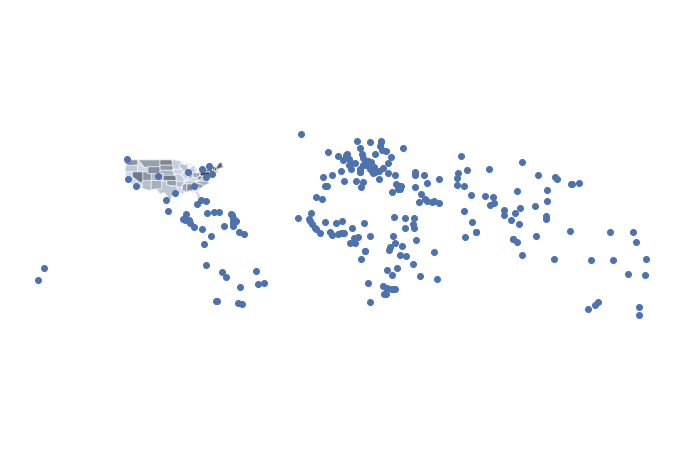

In [3]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=.5,
                        ax=ax)

state_boundary_us.plot(cmap="Greys",
                      ax=ax,
                      alpha=.5)
pop_places.plot(ax=ax)

plt.axis("equal")
ax.set_axis_off()
plt.show()

## Clip the points shapefile using geopandas

![vector-clip](vector-clip.png)

EarthPy developed a clip_shp() function that would clip and intersection.

Clip() takes 3 arguments:
- gdf: Vector layer (point, line, polygon) to be clipped to mask.
- mask: Polygon vector layer used to clip gdf. The mask's geometry is dissolved into 1 geometric feature and intersected with gdf.
- keep_geom_type: If True, return only geometries of original type in case of intersection resulting in multiple geometry types or GeometryCollections. If False, return all resulting geometries (potentially mixed-types). Default value is False.

clip() will clip the data to the boundary of the polygon layer that you select. If there are multiple polygon in your clip_obj object, clip() will clip the data the total boundary of all polygons in the layer.

In [5]:
# Clip the data using GeoPandas Clip
points_clip = gpd.clip(pop_places, country_boundary_us)

# View the first 6 rows and a few select columns
points_clip[["name", "geometry", "scalerank", "natscale",]].head()

,name,geometry,scalerank,natscale
175,San Francisco,POINT (-122.41717 37.76920),1,300
176,Denver,POINT (-104.98596 39.74113),1,300
177,Houston,POINT (-95.34193 29.82192),1,300
178,Miami,POINT (-80.22605 25.78956),1,300
179,Atlanta,POINT (-84.40190 33.83196),1,300


Now, you can plot the data to see the newly "clipped" points layer.

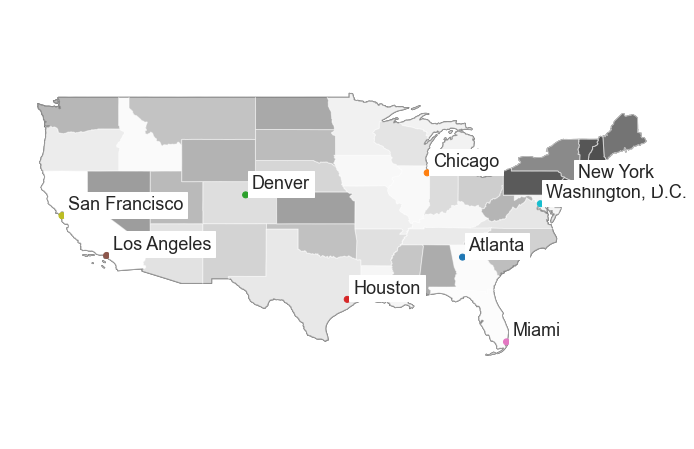

In [7]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                        color="white",
                        edgecolor="black",
                        ax=ax)

state_boundary_us.plot(cmap="Greys",
                      ax=ax,
                      alpha=.5)

points_clip.plot(ax=ax,
                column="name")
ax.set_axis_off()
plt.axis("equal")

# Label each npoint
points_clip.apply(lambda x: ax.annotate(s=x["name"],
                                       xy=x.geometry.coords[0],
                                       xytext=(6, 6), textcoords="offset points",
                                       backgroundcolor="white"),
                  axis=1)
plt.show()

## Clip a line or polygon layer to an extent

The process of clipping a line or polygon layer is slightly different than clipping a set of points. To clip a line of polygon feature:
1. Ensure that your polygon and line layer are in the same CRS
2. Identify what features in the lines layer fall WITHIN the boundary of the polygon layer
3. Subset the features within the geometry and reset the geometry of the newly clipped layer to be equal to the clipped data.

When you clip data using shapely and geopandas the default behaviour is for it to only return the clipped geometry. However you may with to also retrain the attributes associated with the geometry. This is where set_geometry() methods comes into play.

For this example you will use the country_boundary layer and a clipped version of the natural earth 10m raods layer. *Import ne_10m_n_america_roads.shp into python.
- Next, check to ensure that the roads and country boundary are in the same CRS. You may need to reproject the data.
- Because spatial operations take time, It's best if you subset your data as much as possible prior to clipping.

In [8]:
# Open the roads layer
ne_roads_path = os.path.join("data", "spatial-vector-lidar", "global",
                            "ne_10m_roads", "ne_10m_roads.shp")
ne_roads = gpd.read_file(ne_roads_path)

# Are both layers in the same CRS?
if (ne_roads.crs == country_boundary_us.crs):
    print("Both layers are in the same CRS!",
         ne_roads.crs, country_boundary_us.crs)

Both layers are in the same CRS! epsg:4326 epsg:4326


## How to clip lines and polygons

You have 2 layers:
1. A global, natural earth roads layer and
2. A boundary for the US.

If both layers are in the same CRS, you are ready to clip your data.

In [11]:
# Clip data
ne_roads_clip = gpd.clip(ne_roads, country_boundary_us)

# Ignore missing/empty geometries
ne_roads_clip = ne_roads_clip[-ne_roads_clip.is_empty]

print("The Clipped data have fewer line objects (represented by rows):",
      ne_roads_clip.shape, ne_roads.shape)

The Clipped data have fewer line objects (represented by rows): (7363, 32) (56601, 32)


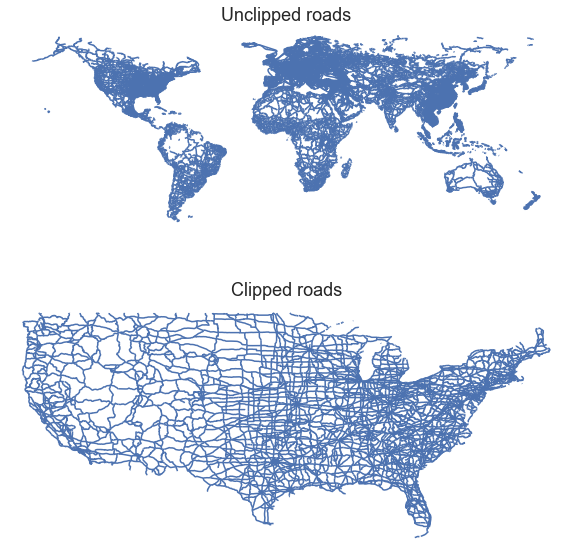

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ne_roads.plot(ax=ax1)
ne_roads_clip.plot(ax=ax2)

ax1.set_title("Unclipped roads")
ax2.set_title("Clipped roads")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis("equal")
plt.show()

Plot the cropped data.

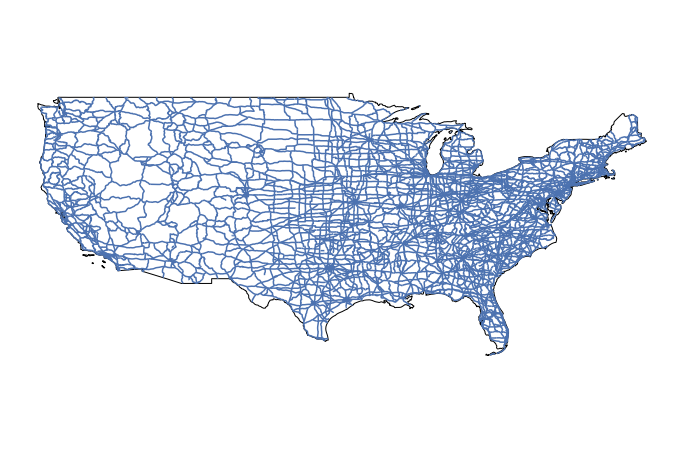

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                        color="white",
                        edgecolor="black",
                        ax=ax)

ne_roads_clip.plot(ax=ax)

ax.set_axis_off()
plt.axis("equal")
plt.show()

* How clip() works:

You'll notice that points, lines,and polygons all have to be handled differently for the clip function to work, which is part of the reason that clip() is so convenient!
1. Subset the roads data using a spatial index.
2. Clip the geometry using .intersection().
3. Remove all rows in the geodataframe that have no geometry (this is explained below).
4. Update the original roads layer to contained only the clipped geometry

In [15]:
# Create a single polygon object for clipping
poly = clip_obj.geometry.unary_union
spatial_index = shp.sindex

# Create a box for the initial intersection
bbox = poly.bounds
# Get a list of id's for each road line that overlaps the bounding box and subset the data to just those lines
sidx = list(spatial_index.intersection(bbox))
shp_sub = shp.iloc[sidx]

# Clip the data - with these data
clipped = shp_sub.copy()
clipped['geometry'] = shp_sub.intersection(poly)

# Return the clipped layer with no null geometry values
final_clipped = clipped[clipped.geometry.notnull()]

NameError: name 'clip_obj' is not defined

## What does simplify do?

AttributeError: 'AxesSubplot' object has no attribute 'set_axix_off'

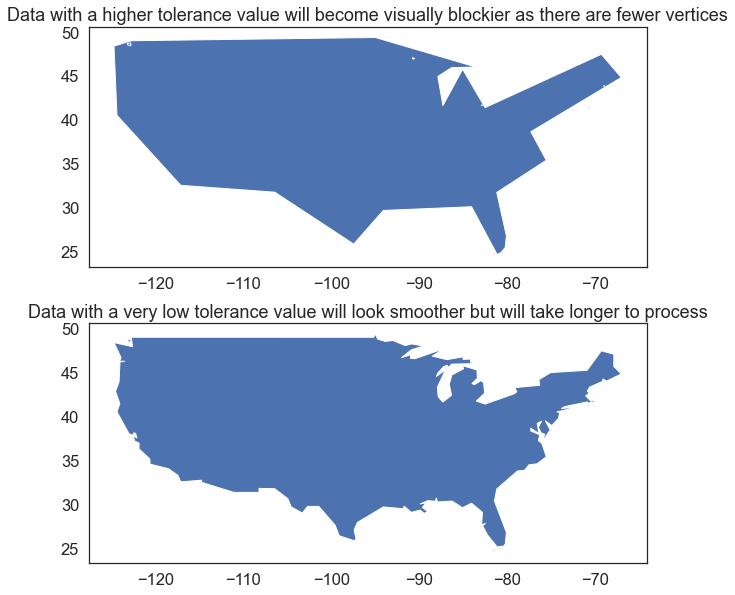

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Set a larger tolerance yields a blockier polygon
country_boundary_us.simplify(2, preserve_topology=True).plot(ax=ax1)

# Set a larger tolerance yields a blockier polygon
country_boundary_us.simplify(.2, preserve_topology=True).plot(ax=ax2)

ax1.set_title(
    "Data with a higher tolerance value will become visually blockier as there are fewer vertices")
ax2.set_title(
    "Data with a very low tolerance value will look smoother but will take longer to process")

ax1.set_axix_off()
ax2.set_axis_off()
plt.show()

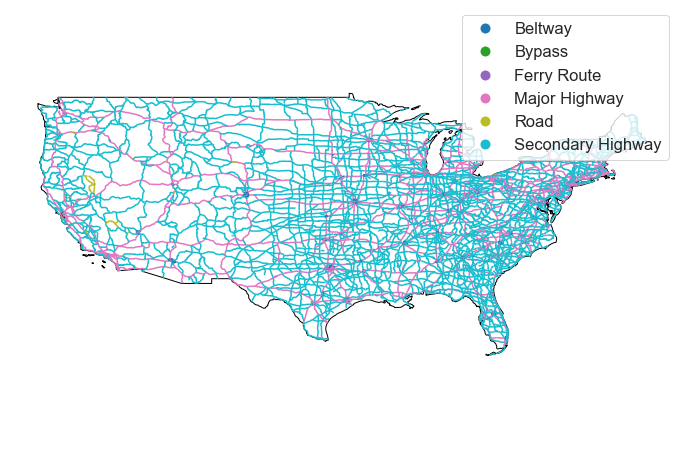

In [17]:
# Plot the data by attribute
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                        color="white",
                        edgecolor="black",
                        ax=ax)

ne_roads_clip.plot(ax=ax,
                   column="type",
                   legend=True)

ax.set_axis_off()
plt.axis("equal")
plt.show()

Below, you create a custom legend.

To begin you create a python dictionary for each attribute value in your legend. Below you will see each road type has a dictionary entry and 2 associated values - a colouzr and a number representing the width of the line in your legend.

"Beltwway": ["black", 2] Colour the line for beltway black with a line width of 2.

Next you loop through the dictionary to plot the data. In the loop below, you select each attribute value, and plot it using the colour and line width assigned in the dictionary above.

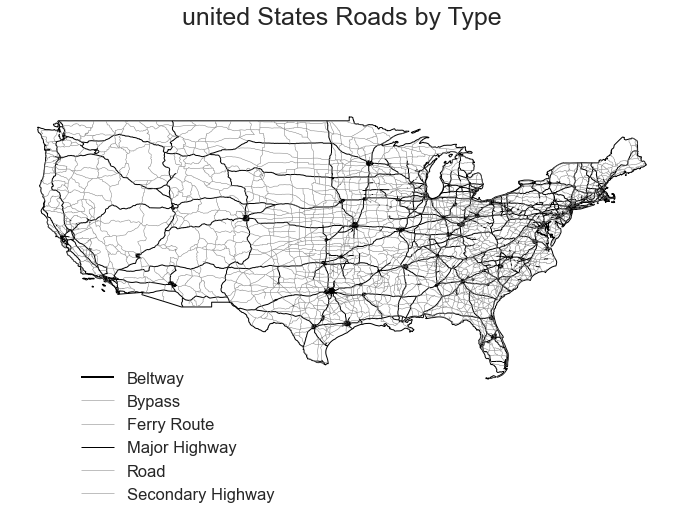

In [21]:
# Plot with a custom legend

# 1st, create a dictionary with the attributes of each legend item
road_attrs = {"Beltway": ["black", 2],
             "Secondary Highway": ["grey", .5],
             "Road": ["grey", .5],
             "Bypass": ["grey", .5],
             "Ferry Route": ["grey", .5],
             "Major Highway": ["black", 1]}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

for ctype, data in ne_roads_clip.groupby("type"):
    data.plot(color=road_attrs[ctype][0],
             label=ctype,
             linewidth=road_attrs[ctype][1],
             ax=ax)
    
country_boundary_us.plot(alpha=1, color="white", edgecolor="black", ax=ax)

ax.legend(frameon=False,
         loc = (0.1, -0.1))

ax.set_title("united States Roads by Type", fontsize=25)
ax.set_axis_off()

plt.axis("equal")
plt.show()